# Thomas fire analysis

In [1]:
import arcgis
from arcgis import *
from arcgis.mapping import MapImageLayer

In [2]:
gis = GIS()

## Visualize the extent of damage

In [3]:
from ipywidgets import *

postfire = MapImageLayer('https://tiles.arcgis.com/tiles/DO4gTjwJVIJ7O9Ca/arcgis/rest/services/Digital_Globe_Imagery_Dec_11th/MapServer')

def side_by_side(address):
    location = geocode(address)[0]
    
    satmap1 = gis.map(location)
    satmap1.basemap = 'satellite'
    
    satmap2 = gis.map(location)
    satmap2.add_layer(postfire)
    
    satmap1.layout = Layout(flex = '1 1', padding = '6px', height = '450px')
    satmap2.layout = Layout(flex = '1 1', padding = '6px', height = '450px')
    
    box = HBox([satmap1, satmap2])
    return box

## Nob Hill, Ventura, CA

In [4]:
side_by_side('Montclair Dr, Ventura, CA')

## Vista Del Mar Hospital, Ventura, CA

In [5]:
side_by_side('801 Seneca St, Ventura, CA 93001')

## Remote Sensing and Image Processing

In [6]:
landsat_item = gis.content.search('title: Multispectral Landsat', 'Imagery Layer', outside_org = True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

## Select before and after rasters

In [7]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'type': 'extent',
       'xmax': -13305000, 'xmin': -13315000, 'ymax': 4106000, 'ymin': 4052000}

arcgis.env.analysis_extent = {"xmin": -13337766, "ymin": 4061097, "xmax": -13224868, "ymax": 4111469,
                              "spatialReference": {"wkid": 102100, "latestWkid": 3857}}

landsat.extent = aoi

In [8]:
import pandas as pd
from datetime import datetime

selected = landsat.filter_by(where="(Category = 1)",
                             time=[datetime(2017, 11, 15), datetime(2018, 1, 1)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(5)

,AcquisitionDate,CloudCover,DayOfYear,GroupName,OBJECTID,SHAPE,Shape_Area,Shape_Length
0,2017-11-23 18:34:42,0.0441,327,LC80420362017327LGN00_MTL,2202594,"{""rings"": [[[-13208036.3849, 4199102.123899996...",5.131484e+10,906509.716682
1,2017-12-09 18:34:40,0.2136,343,LC80420362017343LGN00_MTL,2210579,"{""rings"": [[[-13208251.4004, 4199098.6241], [-...",5.127378e+10,906136.246386
2,2017-12-25 18:34:42,0.6529,359,LC80420362017359LGN00_MTL,2217617,"{""rings"": [[[-13210387.2213, 4199063.157099999...",5.129089e+10,906293.823931


In [9]:
prefire = landsat.filter_by('OBJECTID=668630') # 2017-11-23
midfire = landsat.filter_by('OBJECTID=681950') # 2017-12-09

## Visual Assessment

In [10]:
from arcgis.raster.functions import *

apply(midfire, 'Natural Color with DRA')

## Visualize Burn Scars

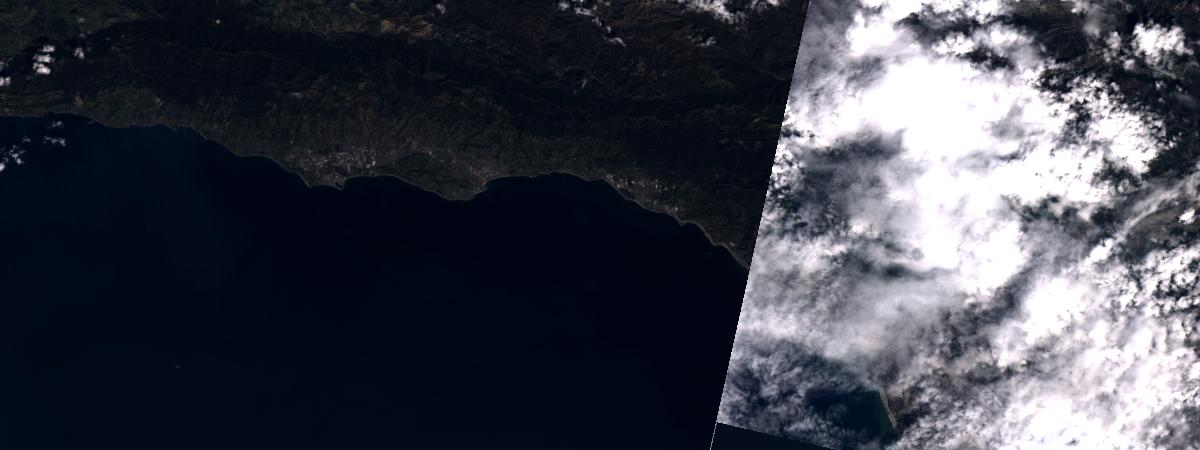

In [11]:
extract_band(midfire, [6, 4, 1])

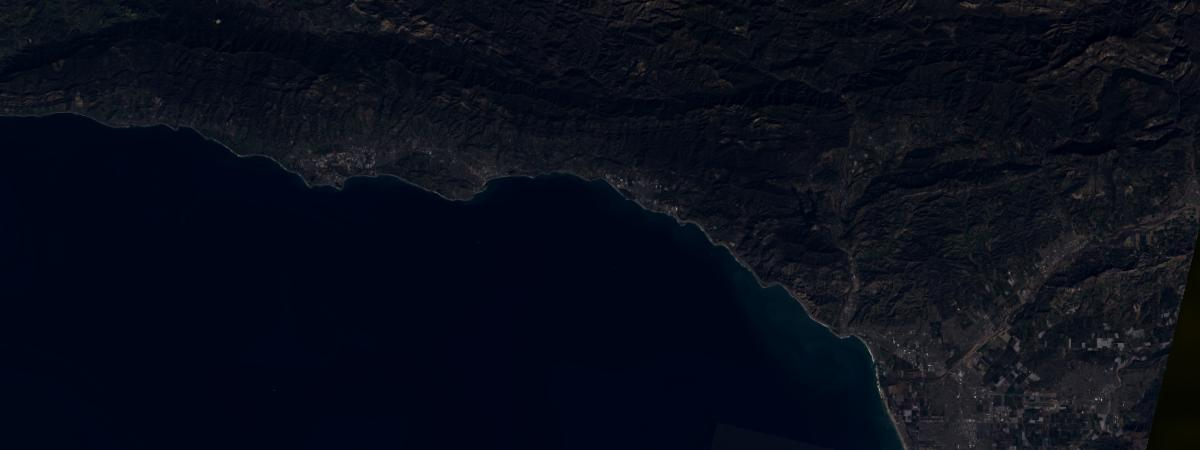

In [12]:
extract_band(prefire, [6, 4, 1])

## Use Band Arithmetic and Map Algebra

In [13]:
nbr_prefire = band_arithmetic(prefire, "(b5 - b7) / (b5 + b7+1000)")
nbr_postfire = band_arithmetic(midfire, "(b5 - b7) / (b5 + b7+1000)")

nbr_diff = nbr_prefire - nbr_postfire

In [14]:
burnt_areas = colormap(remap(nbr_diff,
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'),
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0, 0]])

In [15]:
burnt_areas.draw_graph()

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Area calculation

In [16]:
ext = {"xmax": -13246079.10806628, "ymin": 4035733.9433013694, "xmin": -13438700.419344831, "ymax": 4158033.188557592,
       "spatialReference": {"wkid": 102100, "latestWkid": 3857}, "type": "extent"}

pixx = (ext['xmax'] - ext['xmin']) / 1200.0
pixy = (ext['ymax'] - ext['ymin']) / 450.0

res = burnt_areas.compute_histograms(ext, pixel_size={'x': pixx, 'y': pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

## Report burnt area

In [17]:
from IPython.display import HTML

sqmarea = numpix * pixx * pixy  # in sq. m
acres = 0.00024711 * sqmarea  # in acres

HTML('<h3>Thomas fire has consumed <i>{:,} acres</i>  till {}</h3>.'.format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

ValueError: 'label' must be of length 'x'

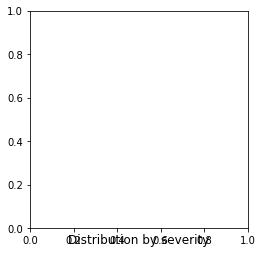

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Distribution by severity', y = -0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 'Moderate Severity', 'High Severity']);
plt.axis('equal');

## Visualize burnt areas

In [19]:
map1 = gis.map('Carpinteria, CA')
map1

MapView(layout=Layout(height='400px', width='100%'))

In [20]:
map1.add_layer([midfire, burnt_areas])

## Raster to Feature layer conversion

In [21]:
from arcgis.geoanalytics.use_proximity import create_buffers

fire_item = burnt_areas.to_features(output_name='ThomasFire_Boundary')

fire_layer = fire_item.layers[0]
fire_layer.filter = 'st_area_sh > 3000000'

fire = create_buffers(lyr, 100, 'Meters', dissolve_option='All', multipart=True, output_name='ThomasFire')

AttributeError: 'PropertyMap' instance has no attribute 'rasterAnalytics'

In [22]:
fire = gis.content.search('Thomas_Fire', 'Feature Layer')[0]
fire

<Item title:"ThomasFire_confirmed_and_reported_building_burns_12082017" type:Feature Layer Collection owner:Nick_Fury>

In [23]:
vectormap = gis.map('Carpinteria, CA')
vectormap.basemap = 'dark-gray'
vectormap.add_layer(fire)
vectormap

MapView(layout=Layout(height='400px', width='100%'))

## Impact Assessment

### Compute infrastructure and human impact

In [24]:
from arcgis.geoenrichment import enrich
from arcgis.features import SpatialDataFrame

sdf = SpatialDataFrame.from_layer(fire.layers[0])

fire_geometry = sdf.iloc[0].SHAPE
sa_filter = geometry.filters.intersects(geometry=fire_geometry, sr=4326)

secondary_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/1")
secondary_roads = secondary_roads_layer.query(geometry_filter=sa_filter, out_sr=4326)

local_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/2")
local_roads = local_roads_layer.query(geometry_filter=sa_filter, out_sr=4326)

def age_pyramid(df):
    import warnings
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.options.mode.chained_assignment = None 
    plt.style.use('ggplot')

    df = df[[x for x in impacted_people.columns if 'MALE' in x or 'FEM' in x]]
    sf = pd.DataFrame(df.sum())
    sf['age'] = sf.index.str.extract('(\d+)').astype('int64')

    f = sf[sf.index.str.startswith('FEM')]
    m = sf[sf.index.str.startswith('MALE')]
    f = f.sort_values(by='age', ascending=False).set_index('age')
    m = m.sort_values(by='age', ascending=False).set_index('age')

    popdf = pd.concat([f, m], axis=1)
    popdf.columns = ['F', 'M']
    popdf['agelabel'] = popdf.index.map(str) + ' - ' + (popdf.index+4).map(str)
    popdf.M = -popdf.M
    
    sns.barplot(x="F", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
    sns.barplot(x="M",  y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
    plt.ylabel('Age group')
    plt.xlabel('Number of people');
    return plt;

NameError: name 'OLD_PANDAS' is not defined

### Visualize affected roads on map

In [25]:
impactmap = gis.map('Carpinteria, CA')
impactmap.basemap = 'streets'

impactmap

MapView(layout=Layout(height='400px', width='100%'))

In [26]:
impactmap.draw([local_roads, secondary_roads])

NameError: name 'local_roads' is not defined

### Age Pyramid of affected population

In [27]:
impacted_people = enrich(sdf, 'Age')
age_pyramid(impacted_people);

NameError: name 'sdf' is not defined